## Análisis del Viento en Asunción con NASA POWER y Winrose

Este repositorio contiene un notebook de Google Colab que consulta datos de velocidad y dirección del viento de la API de NASA POWER y realiza un análisis exploratorio, estacional y de tendencia, además de evaluar el potencial eólico para la instalación de una planta de energía.

Contenido

Consulta de datos: Obtención de datos de velocidad y dirección del viento a escala horaria para Asunción, Paraguay (5 años).

Análisis exploratorio: Visualización de la velocidad del viento y su distribución.

Estacionalidad: Cálculo de promedios mensuales y estacionales.

Distribución de Weibull: Ajuste de la distribución de Weibull para modelar el comportamiento del viento.

Extrapolación de veloc

In [2]:
# Instalación de Winrose y dependencias
!pip install windrose

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from windrose import WindroseAxes


In [4]:

# Definir la ubicación y el período
LAT, LON = -20.42, -61.8  # Asunción, Paraguay
START, END = "2020-01-01", "2024-12-31"



In [5]:
# Consultar datos del portal de NASA POWER
url = f"https://power.larc.nasa.gov/api/temporal/hourly/point?parameters=WS10M,WD10M&community=RE&longitude={LON}&latitude={LAT}&start={START.replace('-', '')}&end={END.replace('-', '')}&format=JSON"
data = requests.get(url).json()

In [6]:

# Convertir a DataFrame
df = pd.DataFrame(data['properties']['parameter']['WS10M'].items(), columns=['timestamp', 'wind_speed'])
df['wind_direction'] = df['timestamp'].map(data['properties']['parameter']['WD10M'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df.set_index('timestamp', inplace=True)



In [7]:
df.head()

,wind_speed,wind_direction
timestamp,,
2020-01-01 00:00:00,1.56,279.9
2020-01-01 01:00:00,1.71,265.7
2020-01-01 02:00:00,1.86,251.5
2020-01-01 03:00:00,1.97,239.8
2020-01-01 04:00:00,2.00,230.5


In [8]:
df.to_csv("datos.csv")

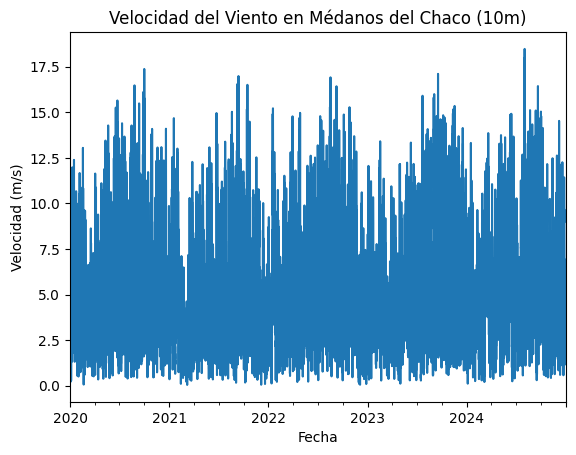

In [20]:

# Análisis exploratorio
df['wind_speed'].plot(title='Velocidad del Viento en Médanos del Chaco (10m)')
plt.xlabel('Fecha')
plt.ylabel('Velocidad (m/s)')
plt.show()



<ipython-input-10-b7b710502882>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M').mean()['wind_speed'].plot(title='Promedio Mensual de Velocidad del Viento')


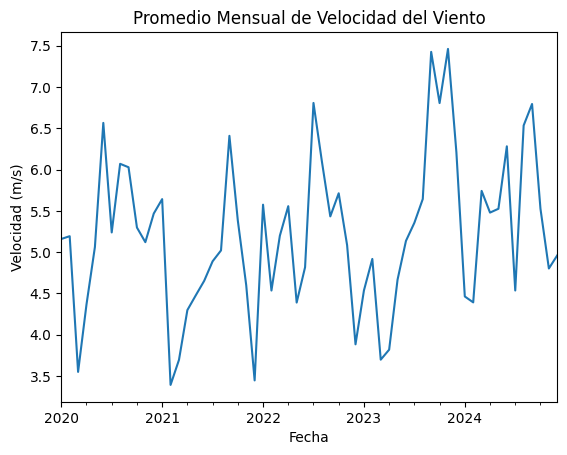

In [10]:
# Estacionalidad: promedio mensual
df.resample('M').mean()['wind_speed'].plot(title='Promedio Mensual de Velocidad del Viento')
plt.xlabel('Fecha')
plt.ylabel('Velocidad (m/s)')
plt.show()


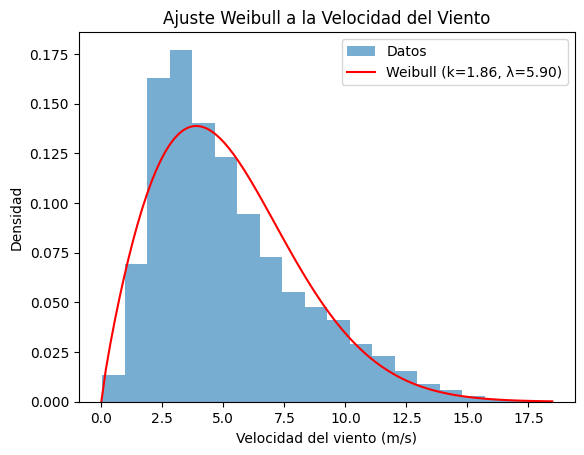

In [11]:
# Ajuste de Weibull
shape, loc, scale = weibull_min.fit(df['wind_speed'], floc=0)
x = np.linspace(0, df['wind_speed'].max(), 100)
pdf = weibull_min.pdf(x, shape, loc, scale)
plt.hist(df['wind_speed'], bins=20, density=True, alpha=0.6, label='Datos')
plt.plot(x, pdf, 'r-', label=f'Weibull (k={shape:.2f}, λ={scale:.2f})')
plt.title('Ajuste Weibull a la Velocidad del Viento')
plt.xlabel('Velocidad del viento (m/s)')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [26]:

# Extrapolación a mayor altura usando la ley de potencia (α ≈ 0.26 para zonas boscosas)
def extrapolate_wind_speed(v10, h1=10, h2=120, alpha=0.26):
    return v10 * (h2 / h1) ** alpha

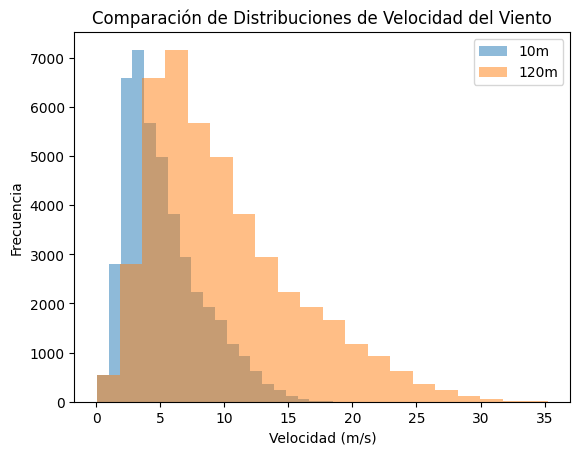

In [27]:

df['wind_speed_120m'] = extrapolate_wind_speed(df['wind_speed'])

# Gráfica de comparación
plt.figure()
plt.hist(df['wind_speed'], bins=20, alpha=0.5, label='10m')
plt.hist(df['wind_speed_120m'], bins=20, alpha=0.5, label='120m')
plt.title('Comparación de Distribuciones de Velocidad del Viento')
plt.xlabel('Velocidad (m/s)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

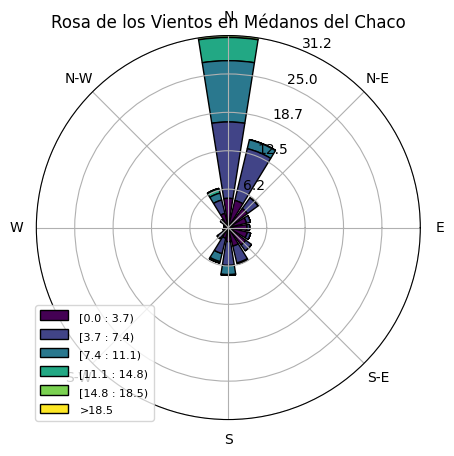

In [35]:
# Rosa de los vientos
fig = plt.figure()
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df['wind_direction'], df['wind_speed'], normed=True, opening=0.8, edgecolor='black')
ax.set_legend()
plt.title('Rosa de los Vientos en Médanos del Chaco')
plt.show()


In [15]:
meses

NameError: name 'meses' is not defined

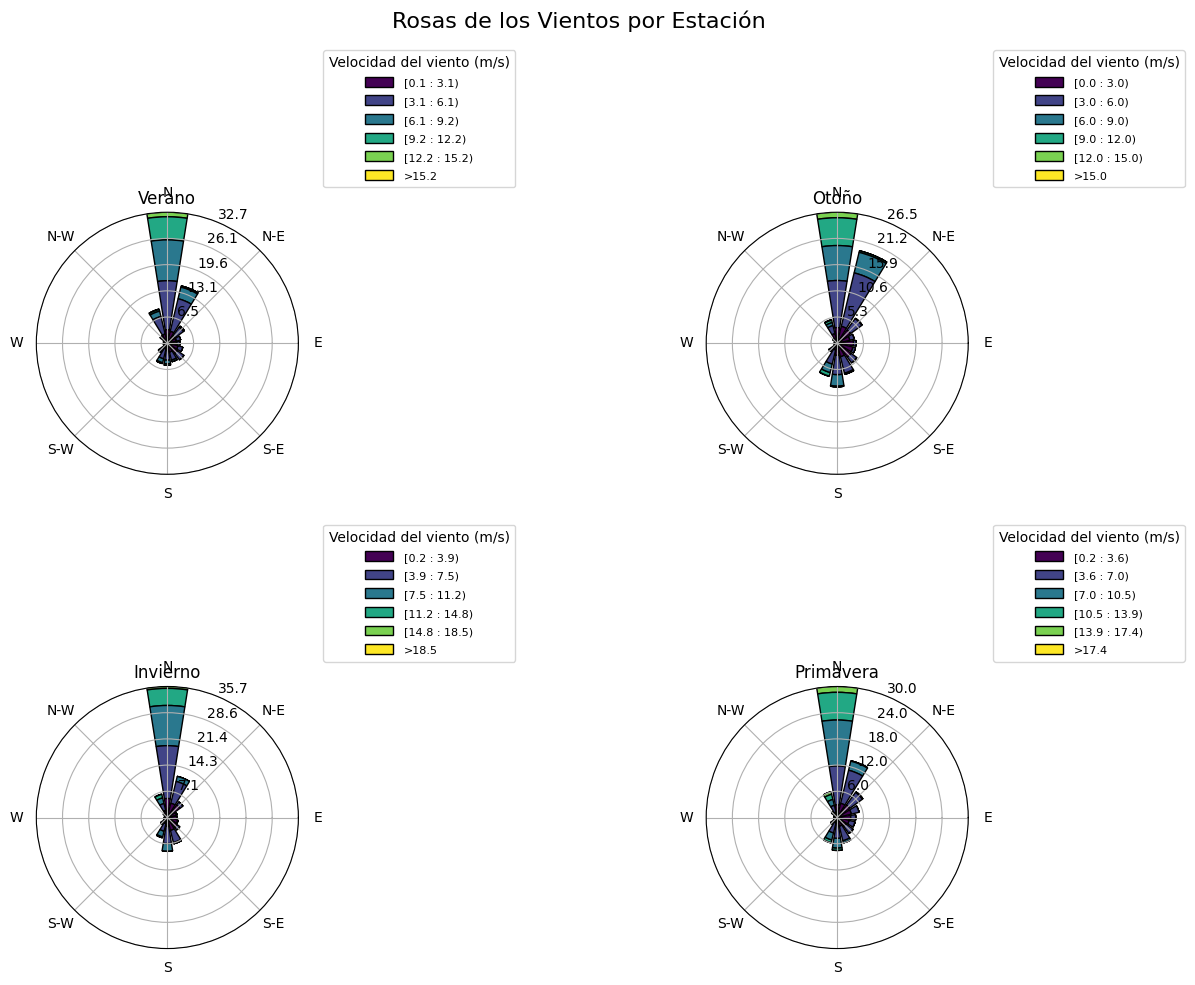

In [36]:

# Definir meses de cada estación
estaciones = {
    'Verano': [12, 1, 2],
    'Otoño': [3, 4, 5],
    'Invierno': [6, 7, 8],
    'Primavera': [9, 10, 11]
}

# Crear una figura con subgráficos para cada estación
fig, axes = plt.subplots(2, 2, figsize=(14, 10), subplot_kw=dict(projection='windrose'))
fig.suptitle("Rosas de los Vientos por Estación", fontsize=16)

# Graficar cada estación en un subgráfico
for i, (estacion, meses) in enumerate(estaciones.items()):
    ax = axes[i // 2, i % 2]  # Seleccionar el subgráfico correspondiente
    seasonal_data = df[df.index.month.isin(meses)]
    ax.bar(seasonal_data['wind_direction'], seasonal_data['wind_speed'], normed=True, opening=0.8, edgecolor='black')
    ax.set_title(estacion, fontsize=12)
    ax.set_legend(title="Velocidad del viento (m/s)", bbox_to_anchor=(1.1, 1.1))  # Leyenda fuera del gráfico

plt.tight_layout()
plt.show()


<ipython-input-37-905be9395309>:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual = df.resample('Y').mean()


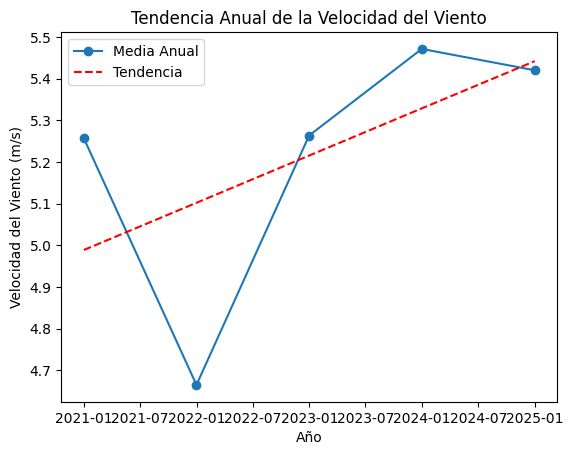

In [37]:
from sklearn.linear_model import LinearRegression

# Estimación de tendencia anual
df_annual = df.resample('Y').mean()
X = np.arange(len(df_annual)).reshape(-1, 1)
y = df_annual['wind_speed'].values
reg = LinearRegression().fit(X, y)
df_annual['trend'] = reg.predict(X)

plt.figure()
plt.plot(df_annual.index, df_annual['wind_speed'], marker='o', label='Media Anual')
plt.plot(df_annual.index, df_annual['trend'], linestyle='--', color='r', label='Tendencia')
plt.title('Tendencia Anual de la Velocidad del Viento')
plt.xlabel('Año')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()

## Criterios para la instalación de una planta eólica

Velocidad del viento: Evaluar si la densidad de potencia del viento es mayor a 200 W/m².

Accesibilidad: Considerar la cercanía a la red eléctrica y facilidad de instalación.

Impacto ambiental y social: Evaluar efectos sobre la biodiversidad y comunidades cercanas.

Variabilidad estacional: Analizar la estabilidad de la velocidad del viento a lo largo del año.

Almacenamiento de energía: Considerar tecnologías para garantizar suministro continuo.

In [38]:

# Evaluación para instalación de planta eólica
def wind_power_density(v, rho=1.225):
    return 0.5 * rho * np.mean(v**3)

power_density_120m = wind_power_density(df['wind_speed_50m'])
print(f"Densidad de potencia del viento a 120m: {power_density_120m:.2f} W/m²")

if power_density_120m > 200:
    print("El sitio tiene potencial para energía eólica.")
else:
    print("El sitio tiene viento insuficiente para una planta eólica.")


# Consideraciones adicionales:
# - Evaluar accesibilidad y conexión a la red eléctrica.
# - Analizar impacto ambiental y social.
# - Considerar variabilidad estacional y almacenamiento de energía.

Densidad de potencia del viento a 120m: 1308.42 W/m²
El sitio tiene potencial para energía eólica.
